<a href="https://colab.research.google.com/github/CalculatedContent/ww-phys_theory/blob/master/Jacobian_Reshaped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook which reshapes the Jacobian as 

$\mathbf{J}\;\;(nK\times d)$ , where

- $N$ num of data points
- $k$ num classes
- $d$ dimension of inputs $(3\times 32\times 32)$







In [1]:
Jdir =  '/content/drive/My Drive/J_paper_test'

thismodel = 'resnet20_cifar10' #'resnet20_cifar10','resnet56_cifar10','resnet110_cifar10','resnet164bn_cifar10', 'resnet272bn_cifar10']
num_classes = 10

num_data = 10000
batch_size = 100

device = 'cuda:0'


In [2]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
!pip install ipython-autotime
%load_ext autotime

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.78 ms


In [5]:
!ls "$Jdir"

time: 790 ms


In [6]:
!pip install pytorchcv
!pip install powerlaw
!pip install GPUtil
import GPUtil

time: 8.74 s


In [7]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

import gc


time: 535 ms


### Run InstallPhysTheory notebook 

In [8]:
import sys
sys.path.append("/content/drive/My Drive/Jacobian")
import jacobian as jac
import utils

time: 8.6 ms


In [9]:
def construct_J( model, data_loader, batch_size, device='cuda:0', num_classes=num_classes, data_dim = 3*32*32):
  """Constructs J matrix for the paper 
  Input: Model, data_loader, batch_size, device, num_classes, data_dim.
  Optional Arguments: device, num_classes (default 10), data_dim (default: 3072).
  Return: expected value  (len(data_loader)*num_classes*batch_size, num_classes*data_dim).
  """
  Js = []
  model.eval()
  model = model.to(device)

  for batch, data in enumerate(data_loader):
    features, labels = data
    inputs = features.to(device)
    inputs.requires_grad=True
    outputs = model(inputs)
    J = jac.batch_diagJ(inputs, outputs)
    Js.append(J)

  full_J = torch.stack(Js, dim=0)

  return full_J

time: 8.47 ms


In [10]:
def jacobian_rect(model, data_loader, batch_size, num_classes=num_classes, device='cuda:0'): 
  '''compute a full of J Rectangular Jacobian directly.  '''

  model.eval()
  model = model.to(device)

  J = construct_paperJ(model, data_loader, batch_size=batch_size, device=device) 
 
  gc.collect()
  torch.cuda.empty_cache()

  return J.detach().cpu().numpy()

time: 4.85 ms


### ResNet 

In [11]:
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

time: 105 ms


### Compute JJ, in batches or all at once


In [12]:
def get_datasets(thismodel, batch_size):
  print("getting dataset for ", thismodel)
  if thismodel.endswith('cifar100'):
    print("loading cifar100")
    train_dataset = datasets.CIFAR100(
      root='data', 
      train=True, 
      transform=transforms.ToTensor(),
      download=True)
    test_dataset = datasets.CIFAR100(
      root='data', 
      train=False, 
      transform=transforms.ToTensor(),
      download=True) 
 
    train_loader = DataLoader(
      dataset=train_dataset, 
      batch_size=batch_size,
      num_workers=4,
      shuffle=False)
    test_loader = DataLoader(
      dataset=test_dataset, 
      batch_size=batch_size,
      num_workers=4,
      shuffle=False)

  else:
    print("loading cifar10")
    train_dataset, test_dataset, train_loader, test_loader = utils.get_data(batch_size=batch_size)

      
  return train_dataset, test_dataset, train_loader, test_loader

time: 9.27 ms


In [17]:
import powerlaw

def fit_esd(evals, thismmodel):
  fit = powerlaw.Fit(evals)
  print("alpha = ",fit.alpha)
  print("xmin = ",fit.xmin)
  R, p = fit.distribution_compare('truncated_power_law', 'lognormal')
  print(R,p)

  h = np.histogram(np.log10(evals),bins=100)
  ih = np.argmax(h[0])
  xmin2 = 10**h[1][ih]

  #fit2 = powerlaw.Fit(evals, parameter_range={'xmin':[xmin2*0.95,xmin2*1.05]} )
  fit2 = powerlaw.Fit(evals, xmin=xmin2 )

  print("alpha = ",fit2.alpha)
  print("xmin = ",fit2.xmin)
  R, p = fit2.distribution_compare('truncated_power_law', 'lognormal')
  print(R,p)

  plt.hist(evals,bins=100);
  plt.axvline(x=fit.xmin, color='red', label=r"$\alpha={:2.4}$".format(fit.alpha))
  plt.axvline(x=fit2.xmin, color='green', label=r"$\alpha={:2.4}$".format(fit2.alpha))
  plt.title("JJ eigenvales, J (kn x d) \n "+thismodel)
  plt.legend()
  plt.show()


  plt.hist(np.log10(evals),bins=100);
  plt.axvline(x=np.log10(fit.xmin), color='red', label=r"$\alpha={:2.4}$".format(fit.alpha))
  plt.axvline(x=np.log10(fit2.xmin), color='green', label=r"$\alpha={:2.4}$".format(fit2.alpha))

  plt.title("log10 JJ eigenvales, J (kn x d) \n "+thismodel)
  plt.legend()
  plt.show()

  fig2 = fit.plot_pdf(color='b', linewidth=2)
  fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
  fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
  fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
  plt.title(thismodel+"  "+r"$\alpha={:2.4}$".format(fit.alpha))
  plt.show()

  return fit.alpha, fit2.alpha

time: 37.6 ms


In [18]:
print(thismodel)
train_dataset, test_dataset, train_loader, test_loader = get_datasets(thismodel, batch_size)#utils.get_data(batch_size=batch_size)
#train_dataset, test_dataset, train_loader, test_loader = utils.get_data(batch_size=batch_size)

print(test_dataset)
GPUtil.showUtilization()


resnet20_cifar10
getting dataset for  resnet20_cifar10
loading cifar10
Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4913725490196078, 0.4823529411764706, 0.4466666666666667], std=[0.24705882352941178, 0.24352941176470588, 0.2615686274509804])
           )
| ID | GPU | MEM |
------------------
|  0 |  0% |  4% |
time: 2 s


In [19]:
modelnames = ['resnet20_cifar10','resnet56_cifar10','resnet110_cifar10','resnet164bn_cifar10', 'resnet272bn_cifar10']

time: 1.38 ms


resnet20_cifar10
| ID | GPU | MEM |
------------------
|  0 | 50% |  4% |


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha =  3.235916101602967
xmin =  3.1146316528320312
0.9469008969494663 0.11063432400577564
alpha =  2.1799583983661224
xmin =  0.8853948179883426
1.8660997778492106 0.43127156270630207


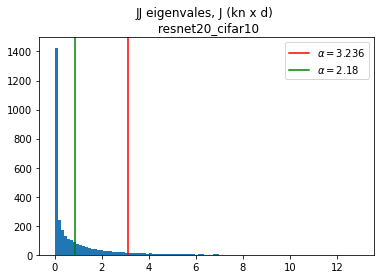

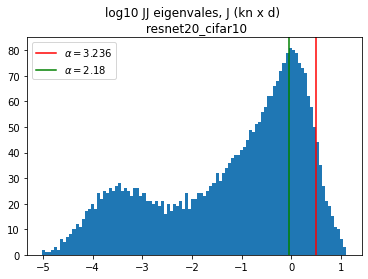

/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


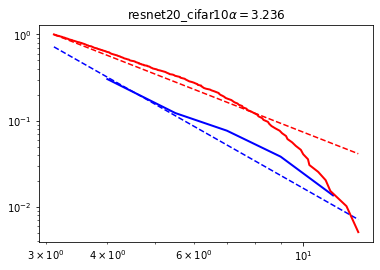

resnet56_cifar10
| ID | GPU | MEM |
------------------
|  0 | 68% |  4% |


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha =  2.930725685338503
xmin =  3.5107336044311523
1.2095655054574541 0.013141167919696368
alpha =  1.8882987288107724
xmin =  0.6024861975899727
6.384134874538525 0.017267080655651683


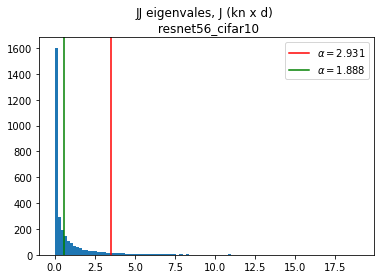

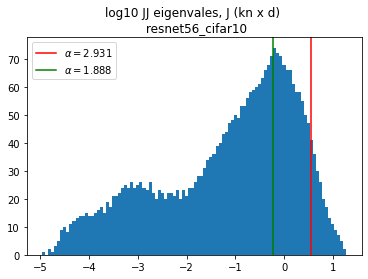

/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


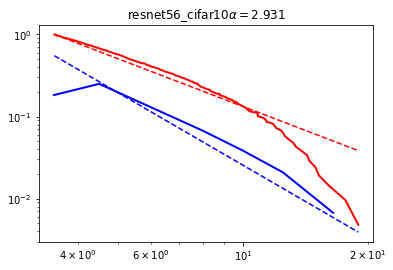

resnet110_cifar10
| ID | GPU | MEM |
------------------
|  0 | 69% |  4% |


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha =  2.9753358112757065
xmin =  3.539335250854492
0.5647152113657619 0.5564045716192043
alpha =  1.8605332668180081
xmin =  0.5429515647667271
8.785405848275749 0.0011403203307285225


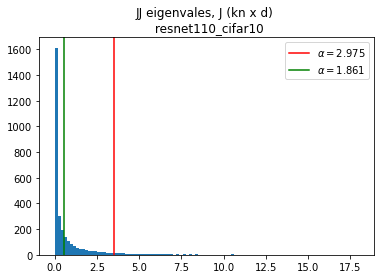

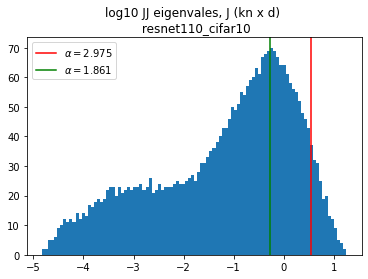

/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


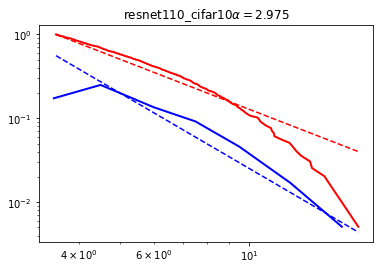

resnet164bn_cifar10
| ID | GPU | MEM |
------------------
|  0 | 88% |  4% |


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha =  1.9099874933538952
xmin =  1.2438112497329712
23.590140495322984 1.8414642442187795e-22
alpha =  1.9204204911000051
xmin =  1.284434046579142
23.602610381693072 1.3290351597512455e-23


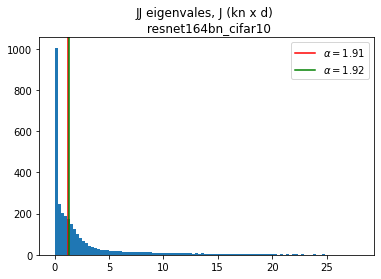

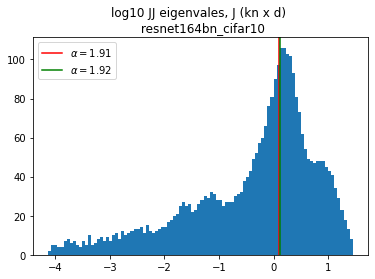

/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


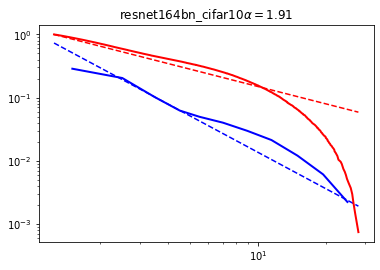

resnet272bn_cifar10
| ID | GPU | MEM |
------------------
|  0 | 92% |  5% |


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha =  7.452151539854581
xmin =  30.833755493164062
0.03525876760046276 0.37064357380640045
alpha =  1.7507853388272807
xmin =  1.0328934293421188
21.494799492385557 1.3701749559114655e-11


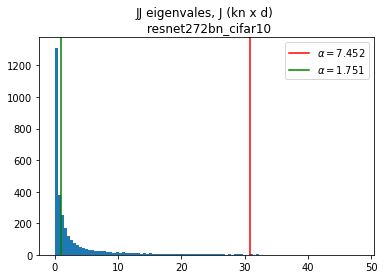

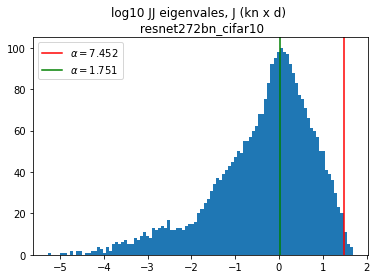

/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


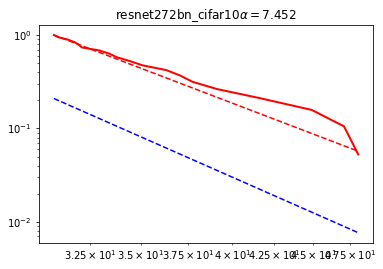

time: 8min 34s


In [20]:
tail_alphas = []
alphas = []
data_loader = test_loader
for thismodel in modelnames:
  print(thismodel)
  model = ptcv_get_model(thismodel, pretrained=True)  
  J_full = construct_J(model, data_loader, batch_size)
  J_full = J_full.reshape(len(data_loader)*batch_size*num_classes, 3*32*32)
  J = J_full.detach().cpu().numpy()

  del J_full
  gc.collect()
  torch.cuda.empty_cache()
  GPUtil.showUtilization()

  JJ = np.dot(np.transpose(J), J)
  #evals = np.linalg.svd(JJ,  compute_uv=False)
  evals = np.linalg.eigvalsh(JJ)
  evals = evals / JJ.shape[0]

  tail_alpha , alpha = fit_esd(evals, thismodel)
  alphas.append(alpha)
  tail_alphas.append(tail_alpha)

In [26]:
alphas

[3.235916101602967,
 2.930725685338503,
 2.9753358112757065,
 1.9099874933538952,
 7.452151539854581]

time: 3.36 ms


### IDK why the pdf plot does not work, but the fit looks **good**

### Expected value over the labels

code below does not work properly yet

In [ ]:
def construct_Jy( model, data_loader, batch_size, device='cuda:0', num_classes=num_classes, data_dim = 3*32*32):
  """Constructs Jy matrix for the paper , where y are the predicted outputs
  Input: Model, data_loader, batch_size, device, num_classes, data_dim.
  Optional Arguments: device, num_classes (default 10), data_dim (default: 3072).
  Return: expected value  (len(data_loader)*num_classes*batch_size, num_classes*data_dim).
  """
  full_Jv = None

  model.eval()
  model = model.to(device)

  for batch, data in enumerate(test_loader):
      features, labels = data
      inputs = features.to(device)
      labels = labels.to(device)
      inputs.requires_grad=True
      outputs = model(inputs)
      J_mat = jac.batch_diagJ(inputs, outputs)

      J_mat = J_mat.reshape(batch_size*num_classes, data_dim)
      outputs_vec =  outputs.reshape(batch_size*num_classes)
      Jv = torch.matmul(outputs_vec, J_mat)
      Jv = Jv.reshape([1,len(Jv)])

      del outputs_vec, J_mat
      gc.collect()
      torch.cuda.empty_cache()

      if full_Jv is not None:
        full_Jv = torch.cat([full_Jv, Jv])
      else:
        full_Jv = Jv

  return full_Jv